In [1]:
from fastai import *
from fastai.vision import *
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from functools import partial
import pretrainedmodels

In [2]:
%matplotlib inline

In [3]:
path = Path(".")
data_path = path / ".." / ".." / ".." / "Dataset" / "Herlev Dataset"
data_path.ls()

[PosixPath('../../../Dataset/Herlev Dataset/abnormal_moderate-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_superficiel'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_light-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_severe-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_columnar'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_intermediate'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_carcinoma-in-situ'),
 PosixPath('../../../Dataset/Herlev Dataset/models')]

In [4]:
data_init = (ImageList.from_folder(data_path)
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (917 items)
x: ImageList
Image (3, 83, 146),Image (3, 106, 116),Image (3, 129, 119),Image (3, 108, 110),Image (3, 209, 173)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../../Dataset/Herlev Dataset;

Test: None

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [6]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=30.0)

In [7]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f565c2cd400>>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

In [8]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [9]:
def model_callback(model, model_name):
    return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

# Fold-1

In [10]:
fold_idxs = idxs[0]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

In [11]:
model_name = 'vgg19_bn' # could be fbresnet152 or inceptionresnetv2
model_cadene = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [12]:
model_cadene.linear0 = torch.nn.Linear(in_features=512 * 2 * 2, out_features=4096)
model_cadene.last_linear =  torch.nn.Linear(model_cadene.last_linear.in_features, int(fold_data.c))
model_cadene.input_size = [3, 64, 64]
model_cadene

VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [13]:
learner = Learner(fold_data, model_cadene, metrics=our_metrics).to_fp16()
learner

Learner(data=ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None, model=VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Con

In [14]:
learner.summary()

VGG
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         1,792      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,928     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
__________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


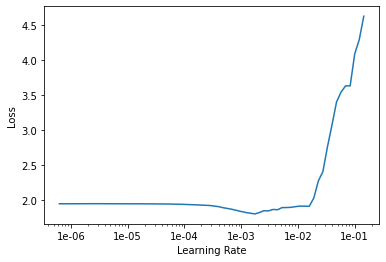

In [15]:
learner.lr_find()
learner.recorder.plot()

In [16]:
learner.fit_one_cycle(30, max_lr=slice(5e-04), callbacks=model_callback(learner, "best-base-vgg19-herlev-multiclass-fold1"))
learner.save("last-base-vgg19-herlev-multiclass-fold1")

Better model found at epoch 0 with accuracy value: 0.21739129722118378.
Better model found at epoch 1 with accuracy value: 0.2554347813129425.
Better model found at epoch 2 with accuracy value: 0.375.
Better model found at epoch 3 with accuracy value: 0.5271739363670349.
Better model found at epoch 5 with accuracy value: 0.570652186870575.
Better model found at epoch 10 with accuracy value: 0.5760869383811951.
Better model found at epoch 11 with accuracy value: 0.592391312122345.
Better model found at epoch 12 with accuracy value: 0.614130437374115.
Better model found at epoch 14 with accuracy value: 0.635869562625885.
Better model found at epoch 17 with accuracy value: 0.6521739363670349.
Better model found at epoch 18 with accuracy value: 0.679347813129425.


# Fold-2

In [17]:
fold_idxs = idxs[1]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


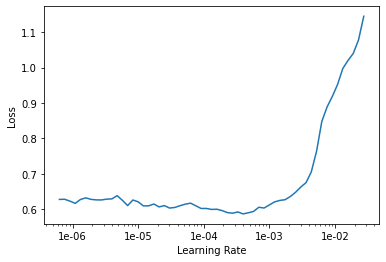

In [19]:
learner.load("best-base-vgg19-herlev-multiclass-fold1")
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(30, max_lr=slice(2e-04), callbacks=model_callback(learner, "best-base-vgg19-herlev-multiclass-fold2"))
learner.save("last-base-vgg19-herlev-multiclass-fold2")

Better model found at epoch 0 with accuracy value: 0.85326087474823.
Better model found at epoch 1 with accuracy value: 0.864130437374115.
Better model found at epoch 2 with accuracy value: 0.875.


# Fold-3

In [21]:
fold_idxs = idxs[2]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


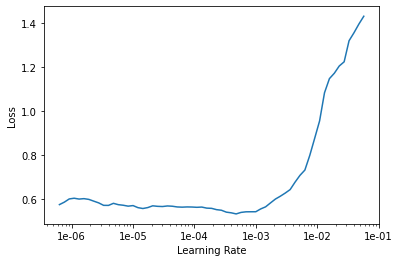

In [22]:
learner.load("best-base-vgg19-herlev-multiclass-fold2")
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [23]:
learner.fit_one_cycle(30, max_lr=slice(2e-04), callbacks=model_callback(learner, "best-base-vgg19-herlev-multiclass-fold3"))
learner.save("last-base-vgg19-herlev-multiclass-fold3")

Better model found at epoch 0 with accuracy value: 0.8961748480796814.
Better model found at epoch 2 with accuracy value: 0.9125683307647705.


# Fold-4

In [24]:
fold_idxs = idxs[3]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


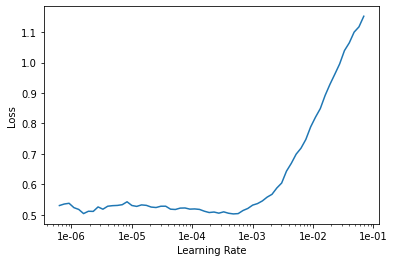

In [25]:
learner.load("best-base-vgg19-herlev-multiclass-fold3")
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [26]:
learner.fit_one_cycle(30, max_lr=slice(3.2e-04), callbacks=model_callback(learner, "best-base-vgg19-herlev-multiclass-fold4"))
learner.save("last-base-vgg19-herlev-multiclass-fold4")

Better model found at epoch 0 with accuracy value: 0.8797814249992371.
Better model found at epoch 1 with accuracy value: 0.8852459192276001.


# Fold-5

In [27]:
fold_idxs = idxs[4]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


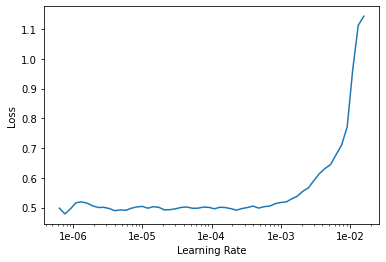

In [29]:
learner.load("best-base-vgg19-herlev-multiclass-fold4")
learner.data = fold_data
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(30, max_lr=slice(1.7e-06), callbacks=model_callback(learner, "best-base-vgg19-herlev-multiclass-fold5"))
learner.save("last-base-vgg19-herlev-multiclass-fold5")

Better model found at epoch 0 with accuracy value: 0.8961748480796814.
Better model found at epoch 1 with accuracy value: 0.9071038365364075.


# Exporting model

In [31]:
learner.load("best-base-vgg19-herlev-multiclass-fold5")
learner.export("best-base-vgg19-herlev-multiclass-5fold.pkl")

# Results (save results.csv first)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compute_results(fname):
    df = pd.read_csv(fname)
    print(df)
    print("*-*" * 10)
    print("Results :-")
    mean_df = np.mean(df, axis=0)
    mean_error_df = np.mean(np.abs(mean_df - df), axis=0)
    for col, mean, error in zip(list(df.columns), list(mean_df.values), list(mean_error_df.values)):
        print(f"{col.capitalize()} : {mean * 100:.4f} % | { error * 100:.4f} %")

compute_results("results.csv")

   accuracy  precision    recall    f_beta  kappa_score
0  0.907104   0.925001  0.928628  0.927180     0.947285
1  0.885246   0.906811  0.909750  0.908642     0.953798
2  0.912568   0.922137  0.934825  0.930568     0.945139
3  0.875000   0.891732  0.891701  0.890999     0.939373
4  0.679348   0.765525  0.697314  0.703085     0.777440
*-**-**-**-**-**-**-**-**-**-*
Results :-
Accuracy : 85.1853 % | 6.9002 %
Precision : 88.2241 % | 4.6686 %
Recall : 87.2444 % | 7.0052 %
F_beta : 87.2095 % | 6.7604 %
Kappa_score : 91.2607 % | 5.4067 %
